In [35]:
import pandas as pd
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from skimage.color import rgb2gray
from skimage.feature import hog
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE

In [36]:
def util_map(is_malignant):
    if is_malignant:
        return 1
    else:
        return 0

total = pd.read_csv('data/ddi_metadata.csv')
total['aux'] = total['malignant'].map(util_map)
skin_tones = {}
skin_tones[12] = total.query('skin_tone == 12')
skin_tones[34] = total.query('skin_tone == 34')
skin_tones[56] = total.query('skin_tone == 56')

In [37]:
def extract_hog_features(img_path):
    image = cv2.imread(img_path)
    image = cv2.resize(image, (256, 256))

    gray_image = rgb2gray(image)

    hog_features = hog(gray_image, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), block_norm='L2-Hys', visualize=False)

    return hog_features

In [38]:
def predict_all(df, loops=100):
    features = []
    labels = []

    for row in df.to_dict(orient='records'):
        features.append(extract_hog_features(f'data/{row['DDI_file']}'))
        labels.append(row['aux'])

    X = np.array(features)
    y = np.array(labels)
    
    general_accuracy = 0
    general_precision = 0
    general_confusion_matrix = np.zeros((2, 2), dtype=float)

    for i in tqdm(range(loops)):
        pca = PCA(n_components=100)
        X_pca = pca.fit_transform(X)

        sm = SMOTE()
        X_resampled, y_resampled = sm.fit_resample(X_pca, y)

        X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2)

        clf = RandomForestClassifier(n_estimators=100)
        clf.fit(X_train, y_train)

        y_pred = clf.predict(X_test)
        #print(classification_report(y_test, y_pred))
        general_confusion_matrix += confusion_matrix(y_test, y_pred, labels=[0, 1])

        general_accuracy += accuracy_score(y_test, y_pred)
        general_precision += precision_score(y_test, y_pred, average='macro')

    general_accuracy = general_accuracy/loops
    general_precision = general_precision/loops

    print('\n---------------------------------------------------')
    print(f'General Accuracy = {general_accuracy}')
    print(f'General Precision = {general_precision}')

    
    return general_confusion_matrix/loops

100%|██████████| 100/100 [01:43<00:00,  1.04s/it]


---------------------------------------------------
General Accuracy = 0.8375773195876285
General Precision = 0.840351054296224


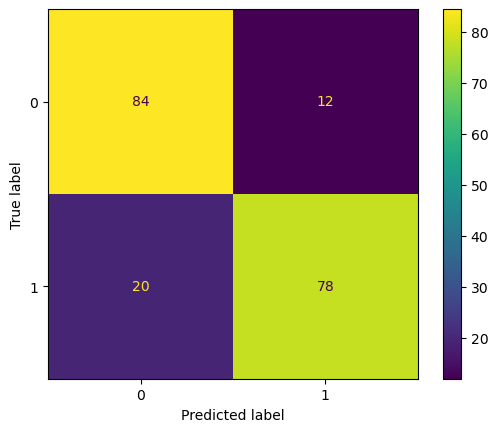

In [39]:
cm = predict_all(total)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot()
plt.show()

100%|██████████| 100/100 [00:43<00:00,  2.28it/s]


---------------------------------------------------
General Accuracy = 0.89421875
General Precision = 0.8965658089582901


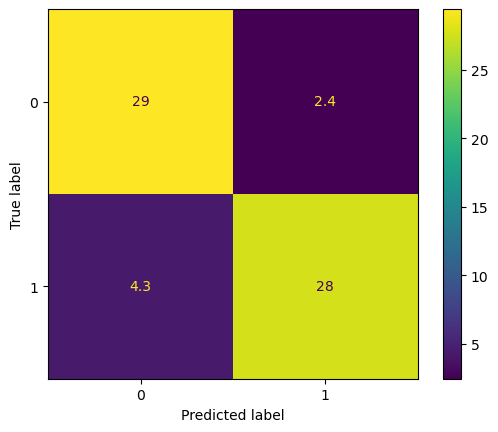

In [40]:
cm = predict_all(skin_tones[12])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot()
plt.show()

100%|██████████| 100/100 [00:46<00:00,  2.15it/s]


---------------------------------------------------
General Accuracy = 0.7988059701492536
General Precision = 0.8047945881304374


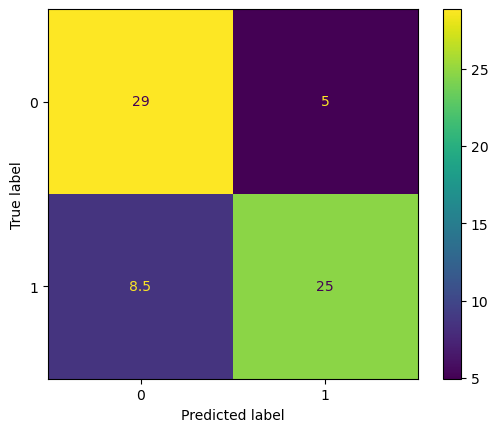

In [41]:
cm = predict_all(skin_tones[34])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot()
plt.show()

100%|██████████| 100/100 [00:44<00:00,  2.22it/s]


---------------------------------------------------
General Accuracy = 0.87359375
General Precision = 0.8745967533590665


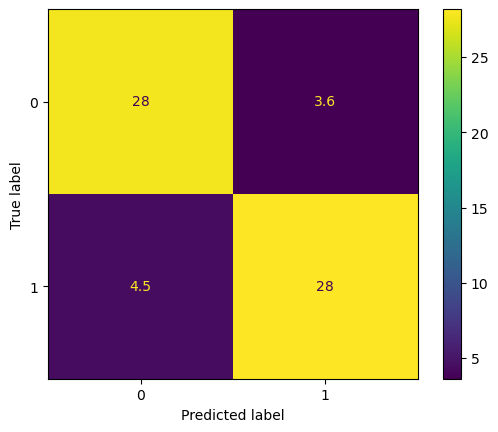

In [42]:
cm = predict_all(skin_tones[56])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot()
plt.show()